# Example 2 - Compute Curie depth

Bouligand *et al.* (2009) formulated an expression for the radial power assuming a fractal model for crustal magnetisation (see [Ex1-Plot-power-spectra](./Ex1-Plot-power-spectrum.ipynb) for analytic solution), which depends on 4 parameters:

- $\beta$ - a fractal parameter
- $z_t$ - top of magnetic sources
- $\Delta z$ - thickness of the magnetic layer
- $C$ - a field constant

These parameters can be fitted to the radial power spectrum computed from FFT to determine Curie depth ($z_\mathrm{curie} = z_t + \Delta z$).

### Contents

- [Plot radial power spectrum](#Plot-radial-power-spectrum)
- [Optimise parameters](#Optimise-parameters)
- [Varying window sizes](#Varying-window-sizes)
- [Add prior constraints](#Add-prior-constraints)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

In [13]:
# load magnetic anomaly - i.e. random fractal noise
mag_data = np.loadtxt("../../data/test_mag_data_mul.txt")

#nx, ny = 305, 305

x = mag_data[:,0]
y = mag_data[:,1]
nx=len(np.unique(x))   
ny=len(np.unique(y))
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

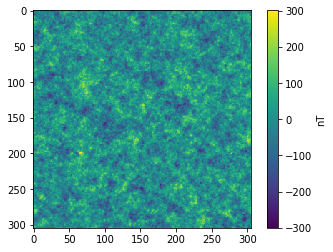

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
im1 = ax1.imshow(d)
fig.colorbar(im1, label='nT')

## Plot radial power spectrum

The radial power spectrum is computed from a square window of the magnetic anomaly. Methods to select window sizes and compute the Fast Fourier Transform (FFT) belong to the `CurieGrid` object. We apply the default `np.hanning` taper to the power spectrum as in [Ex1-Plot-power-spectrum](#./Ex1-Plot-power-spectrum.ipynb).

In [17]:
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)

# pick the centroid
xpt = 0.5*(xmin + xmax)
ypt = 0.5*(ymin + ymax)

window_size = 200e3
subgrid = grid.subgrid(window_size, xpt, ypt)

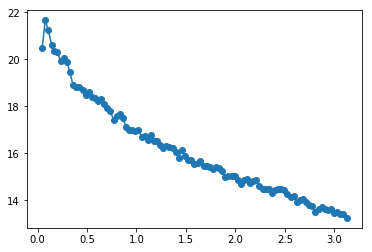

In [18]:
k, Phi, sigma_Phi = grid.radial_spectrum(subgrid)

# plot radial power spectrum
plt.plot(k, Phi, '-o')

## Optimise parameters

The `optimise` routine determines the Curie parameters ($\beta, z_t, \Delta z, C$) by minimising the misfit between the analytic power spectum and the computed power spectrum. Optimisation is handles by the nonlinear least-squares algorithm implemented in `scipy.optimize.minimize`.

```python
optimise(window, xc, yc, beta=3.0, zt=1.0, dz=10.0, C=5.0)
```

These are sane defaults to initiate the optimisation, however, values close to the final solution will result in faster convergence and stability.


Curie depth is 0.06 km

Curie depth is 5.23 km


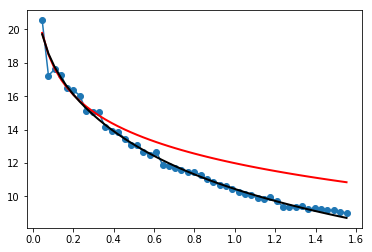

In [7]:
ifre=0.3

beta, zt, dz, C = grid.optimise(ifre, window_size, xpt, ypt)

Phi2 = pycurious.bouligand2009(k, beta, zt, dz, C)
Phi3 = pycurious.bouligand2009(k, 3.0, 0.305, 10.0, -18)
# plot radial power spectrum - compare analytic against computed
plt.plot(k, Phi, '-o')
plt.plot(k, Phi2,color='red', linewidth=2)
print("\nCurie depth is {:.2f} km".format(zt + dz))

ifre=1.5

beta, zt, dz, C = grid.optimise(ifre, window_size, xpt, ypt)
Phi3 = pycurious.bouligand2009(k, beta, zt, dz, C)
plt.plot(k, Phi3,color='black', linewidth=2)
print("\nCurie depth is {:.2f} km".format(zt + dz))

## Varying window sizes

Here, we observe the effect decreasing the window size has on the optimisation of Curie parameters. The number of points in the power spectrum decrease with smaller window sizes, particularly at low wavenumbers (long wavelengths). This significantly reduces the quality of Curie depth determinations for window sizes less than 200 km.

As a rule of thumb, the window size should be > 4 times the maximum possible Curie depth that could be resolved from a study area.

In [ ]:

# window size in kilometres
window_size_range = [304e3, 200e3, 100e3, 50e3]


fig = plt.figure()
ax1 = fig.add_subplot(111)

for i, window_size in enumerate(window_size_range):
    
    # compute radial power spectrum
    subgrid = grid.subgrid(window_size, xpt, ypt)
    k, Phi, sigma_Phi = grid.radial_spectrum(subgrid)
    ax1.plot(k, Phi, '-o', color='C{}'.format(i), label="window size = {}km".format(window_size/1e3))
    
    # optimise Curie variables
    beta, zt, dz, C = grid.optimise(window_size, xpt, ypt)
    print("windows_size = {:.2f}\n  beta = {:.2f}\n  zt = {:.2f}\n  dz = {:.2f}\n   C = {:.2f}\n".format(window_size/1000, beta,zt,dz,C))
    
    Phi2 = pycurious.bouligand2009(k, beta, zt, dz, C)
    ax1.plot(k, Phi2, color='black'.format(i), linewidth=2)

ax1.legend()

## Add prior constraints

Spurious Curie depth values can often be obtained if windows of the magnetic anomaly do not contain long wavelengths. This often arises from selecting too small a small window size, but can also occur from uncorrected artefacts in the magnetic anomaly, or simply the absence of magnetic minerals close to the surface of the crust. Adding *a priori* information on $\beta, z_t, \Delta z, C$ can reduce the incidence of anomalous values if there is reasonable grounds to do so.

> **IMPORTANT:** strict priors can unfairly bias the results - *only* add priors if you have good reason to do so. (This is **not recommended** for most use cases.)

```python
from scipy import stats

# define normal distributions
beta_p = stats.norm(3.0, 1.0)
zt_p = stats.norm(0.0, 1.0)
dz_p = stats.norm(10.0, 8.0)
C_p = stats.norm(10.0, 10.0)

# add to grid object
grid.add_prior(beta=beta_p, zt=zt_p, dz=dz_p, C=C_p)
```

Priors can be accessed from a dictionary:

```python
prior = grid.prior_pdf['beta'] # stats.norm object
prior = grid.prior['beta'] # stats.norm object arguments (3.0, 1.0)
```

A combination of priors can be added. `reset_priors()` removes all prior information.

In [ ]:
grid.reset_priors()
Phi3 = pycurious.bouligand2009(k, 3.0, 0.305, 10.0, -18)
from scipy import stats
beta_p = stats.norm(3.0, 0.01)#定义一个正态分布，期望是 3，标准差是0.01
grid.add_prior(beta=beta_p)

fig = plt.figure()
ax1 = fig.add_subplot(111, xlabel="wavenumber (rad/km)", ylabel="radial power spectrum")

for i, window_size in enumerate(window_size_range):
    
    # compute radial power spectrum
    subgrid = grid.subgrid(window_size, xpt, ypt)
    k, Phi, sigma_Phi = grid.radial_spectrum(subgrid)
    ax1.plot(k, Phi, '-o', color='C{}'.format(i), label='{} km window size'.format(window_size*1e-3))
    
    # optimise Curie variables
    beta, zt, dz, C = grid.optimise(window_size, xpt, ypt)
    print("windows_size = {:.2f}\n  beta = {:.2f}\n  zt = {:.2f}\n  dz = {:.2f}\n   C = {:.2f}\n".format(window_size, beta,zt,dz,C))
    
    Phi2 = pycurious.bouligand2009(k, beta, zt, dz, C)
    ax1.plot(k, Phi2, color='C{}'.format(i), linewidth=2)
    
ax1.plot(k, Phi3, color='C{}'.format(i), linewidth=2)
ax1.legend()